In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

Load all results from chunking analysis.

In [5]:
json_dir = Path("../../data/json_csv")
all_smoothed_ppl_values = []
data = []
for json_file in json_dir.glob("*.json"):

    with open(json_file, "r", encoding="utf-8") as f:
        page_content = json.load(f)

    data.append(
        {
            "page_id": page_content["page_id"],
            "words": page_content["all_words_page"],
            "word_smoothed_ppl": page_content["word_smoothed_ppl_page"],
        }
    )

pd_frame = pd.DataFrame(data)

In [10]:
exploded_df = (
    pd_frame.explode(["words", "word_smoothed_ppl"])
    .reset_index(drop=True)
    .convert_dtypes()
)
exploded_df

,page_id,words,word_smoothed_ppl
0,1737359839_00000204,1ꝰ4,1776.659265
1,1737359839_00000204,ganz,88.707751
2,1737359839_00000204,"Europa,",88.707751
3,1737359839_00000204,auf,88.707751
4,1737359839_00000204,welcher,88.707751
...,...,...,...
157736,1737379171_00000132,be,4943.00027
157737,1737379171_00000132,c,4943.00027
157738,1737379171_00000132,e,4943.00027
157739,1737379171_00000132,Q,4943.00027


### Calculate upper bound using IGR based outlier detection and remove extremely faulte pages.

In [15]:
clean_ppl = exploded_df.dropna()
Q1 = np.percentile(clean_ppl["word_smoothed_ppl"], 25)
Q3 = np.percentile(clean_ppl["word_smoothed_ppl"], 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR  # Standard IQR outlier detection

upper_bound

np.float64(272.165088223147)

Distance from Q3 normalized by IQR. (anomalies over 1.5)

In [ ]:
exploded_df["anomaly_score"] = (exploded_df["word_smoothed_ppl"] - Q3) / IQR
exploded_df["anomaly_score"] *= exploded_df["anomaly_score"] > 0

In [20]:
page_df = exploded_df.groupby("page_id")["anomaly_score"].median()
page_df

page_id
1724666584_00000024        -0.0
1724666584_00000095        -0.0
1724666584_00000133        -0.0
1724666584_00000151        -0.0
1724666584_00000169        -0.0
                         ...   
1744303878_00000010    6.329326
1744303878_00000034        -0.0
1744303878_00000068        -0.0
1744303878_00000087        -0.0
1744303878_00000108        -0.0
Name: anomaly_score, Length: 493, dtype: Float64

Remove pages where anomaly score is below 1.5 (faulty pages).

In [21]:
exploded_df = exploded_df[exploded_df["page_id"].isin(page_df[page_df < 1.5].index)]

New threshold calculated after removal of faulty pages.

In [23]:
Q1 = np.percentile(exploded_df["word_smoothed_ppl"], 25)
Q3 = np.percentile(exploded_df["word_smoothed_ppl"], 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR  # Standard IQR outlier detection

upper_bound

np.float64(158.263657881092)

In [24]:
exploded_df.groupby("page_id").mean("word_smoothed_ppl_page").describe()

,word_smoothed_ppl,anomaly_score
count,416.0,416.0
mean,287.738089,2.392663
std,2168.185541,23.869225
min,31.187606,0.0
25%,58.461653,0.0
50%,73.496028,0.039116
75%,104.142716,0.222772
max,40976.712879,450.672578


Word perplexity distribution on the log scale.

/tmp/ipykernel_126864/1904707556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_df["word_smoothed_ppl"] = pd.to_numeric(


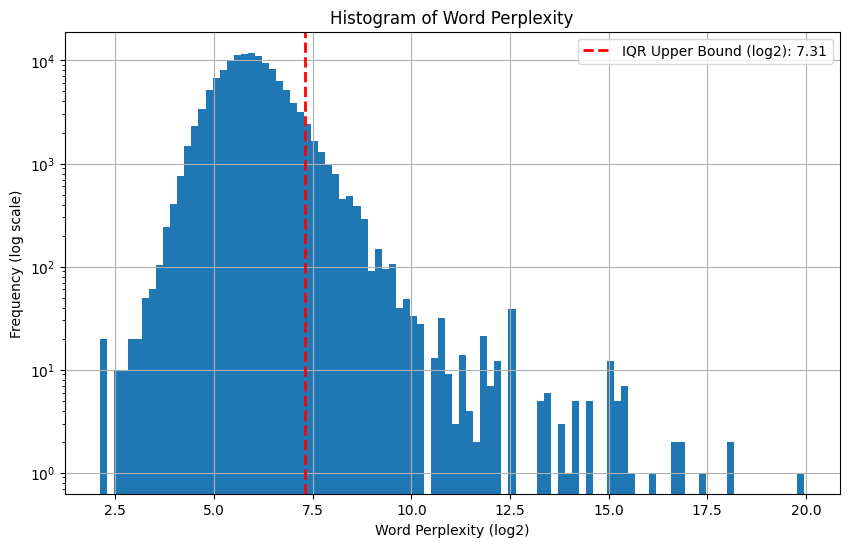

In [27]:
# Convert column to numeric if not already
exploded_df["word_smoothed_ppl"] = pd.to_numeric(
    exploded_df["word_smoothed_ppl"], errors="coerce"
)

# Drop NaNs and non-positive values (log2 undefined for ≤ 0)
filtered = exploded_df[exploded_df["word_smoothed_ppl"] > 0].copy()
log2_ppl = np.log2(filtered["word_smoothed_ppl"])
fig, ax = plt.subplots(figsize=(10, 6))

log2_ppl.hist(bins=100, log=True, ax=ax)

ax.set_title("Histogram of Word Perplexity")
ax.set_xlabel("Word Perplexity (log2)")
ax.set_ylabel("Frequency (log scale)")

# Plot the upper bound as vertical line
upper_bound_log2 = np.log2(upper_bound)
ax.axvline(
    x=upper_bound_log2,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"IQR Upper Bound (log2): {upper_bound_log2:.2f}",
)

ax.legend()
ax.grid(True)
plt.show()

/tmp/ipykernel_126864/2312447924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploded_df["word_smoothed_ppl"] = pd.to_numeric(


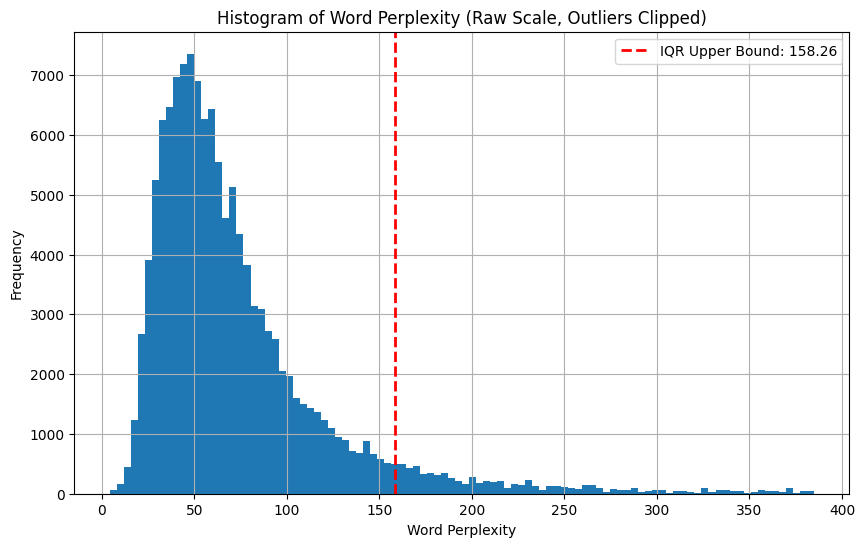

In [32]:
# 1. Ensure values are numeric and drop invalid entries
exploded_df["word_smoothed_ppl"] = pd.to_numeric(
    exploded_df["word_smoothed_ppl"], errors="coerce"
)
filtered = exploded_df[exploded_df["word_smoothed_ppl"] > 0].copy()

# 2. Optionally clip extreme values to improve visibility
# e.g., clip at 99th percentile to reduce skew from outliers
clip_threshold = filtered["word_smoothed_ppl"].quantile(0.99)
clipped = filtered[filtered["word_smoothed_ppl"] <= clip_threshold]

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 6))

clipped["word_smoothed_ppl"].hist(bins=100, ax=ax)

ax.set_title("Histogram of Word Perplexity (Raw Scale, Outliers Clipped)")
ax.set_xlabel("Word Perplexity")
ax.set_ylabel("Frequency")

# Optional: Add upper bound line if it's within visible range
if upper_bound <= clip_threshold:
    ax.axvline(
        x=upper_bound,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"IQR Upper Bound: {upper_bound:.2f}",
    )
    ax.legend()

ax.grid(True)
plt.show()